In [ ]:
# load single trials of rating period

# overview

purpose: look at group average maps from nilearn sngle trials
see if adding amp up and ramp down event increases effect size and eliminates weird artifacts

In [1]:
import numpy as np
import glob
import os
import pathlib
import re
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img, new_img_like
from nilearn import image, plotting
import argparse
import matplotlib.pyplot as plt
from surfplot import Plot
from matplotlib import cm
import neuromaps
import nibabel as nib
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps


In [2]:
def plot_surf(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh, size=(200, 600), zoom=1.6, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=nilearn_cmaps['cold_hot'],#cm.seismic, 
                cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()

def plot_surf_box(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh) #, size=(600, 600)) #, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=nilearn_cmaps['cold_hot'],#cm.seismic, 
                cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()


def extract_ses_and_run(flist):
    # Initialize empty sets to store unique values of 'ses' and 'run'
    unique_ses = set()
    unique_run = set()

    # Loop through each file path and extract 'ses-##' and 'run-##' using regular expressions
    for path in flist:
        # Extract 'ses-##' using regular expression
        ses_match = re.search(r'ses-(\d+)', path)
        if ses_match:
            unique_ses.add(ses_match.group(0))

        # Extract 'run-##' using regular expression
        run_match = re.search(r'run-(\d+)', path)
        if run_match:
            unique_run.add(run_match.group(0))

    # Print the unique values of 'ses' and 'run'
    print(f"Unique ses values: {sorted(unique_ses)}")
    print(f"Unique run values: {sorted(unique_run)}")
    return list(sorted(unique_ses)), list(sorted(unique_run))


In [3]:

# %% load participant data. average per run
# beta_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown'
# save_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/deriv03_univariate/contrast_stimhigh-GT-stimlow'
# save_betanpy = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
beta_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown'
save_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv03_univariate/contrast_stimhigh-GT-stimlow'
save_betanpy = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'

sub_list = sorted(next(os.walk(beta_dir))[1])
groupmean = []; groupmeanL = []; groupmeanH = []
task = 'pain' # 'pain' 'cognitive'
# %%
slurm_id = 2
testlist = sub_list[slurm_id]
# %%
for sub in [testlist]:
    print(f"_____________{sub}_____________")
    flist= glob.glob(os.path.join(beta_dir, sub, f"{sub}_*{task}*.nii.gz"))
    unique_ses, unique_run = extract_ses_and_run(flist)
    sesmean = []
    sesmean_L, sesmean_H = [], []
    npy_path = pathlib.Path(os.path.join(save_betanpy, sub))
    npy_path.mkdir(parents = True, exist_ok = True)
    for ses in unique_ses:

        runstackL = []; runstackH = []
        for run in unique_run:
            print(run)
            runmeanimg = []
            runmeanconcat = []
            matching_files = []

            stimL_flist = glob.glob(os.path.join(beta_dir, sub, f"{sub}_{ses}_{run}*{task}*event-stimulus_*_stimintensity-low*.nii.gz"))
            stimM_flist = glob.glob(os.path.join(beta_dir, sub, f"{sub}_{ses}_{run}*{task}*event-stimulus_*_stimintensity-med*.nii.gz"))
            stimH_flist = glob.glob(os.path.join(beta_dir, sub, f"{sub}_{ses}_{run}*{task}*event-stimulus_*_stimintensity-high*.nii.gz"))
            print(stimL_flist)
            for stimL_fpath in stimL_flist:
                # stimL_img = []
                stimL_img = image.load_img(stimL_fpath)
                np.save(os.path.join(npy_path, os.path.splitext(os.path.splitext(os.path.basename(stimL_fpath))[0])[0] + '.npy'), stimL_img.get_fdata())

            for stimM_fpath in stimM_flist:
                stimM_img = image.load_img(stimM_fpath)
                np.save(os.path.join(npy_path, os.path.splitext(os.path.splitext(os.path.basename(stimM_fpath))[0])[0] + '.npy'), stimM_img.get_fdata())

            for stimH_fpath in stimH_flist:
                stimH_img = image.load_img(stimH_fpath)
                np.save(os.path.join(npy_path, os.path.splitext(os.path.splitext(os.path.basename(stimH_fpath))[0])[0] + '.npy'), stimH_img.get_fdata())
 

_____________sub-0004_____________
Unique ses values: ['ses-01']
Unique run values: ['run-02', 'run-04']
run-02
['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/sub-0004/sub-0004_ses-01_run-02_runtype-pain_event-stimulus_trial-001_cuetype-low_stimintensity-low.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/sub-0004/sub-0004_ses-01_run-02_runtype-pain_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/sub-0004/sub-0004_ses-01_run-02_runtype-pain_event-stimulus_trial-003_cuetype-high_stimintensity-low.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/sub-0004/sub-0004_ses-01_run-02_runtype-pain_event-stimulus_trial-006_cuetype-high_stimintensity-low.nii.gz']
run-04
['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/sub-0004/sub-0004_ses-01_run-04_runtype-pain_event-stimu

load group data

In [10]:
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'                                     
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-high.npy"))

In [11]:
suballLv.shape

(3, 458294)

In [12]:
# create mask from canlab mask. Use sample single trial as target shape/affine
imgfname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    memory="nilearn_cache", memory_level=1)

In [13]:
x,y,z=ref_img.shape
H = []
L = []
for index in range(suballLv.shape[0]):
    # apply masker onto numpy array (shape of #subjects x voxels)
        
    H.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    L.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )
    


In [14]:
fmri_masked_stimhigh = np.vstack(H)
fmri_masked_stimlow = np.vstack(L)
print(fmri_masked_stimlow.shape)

(3, 98053)


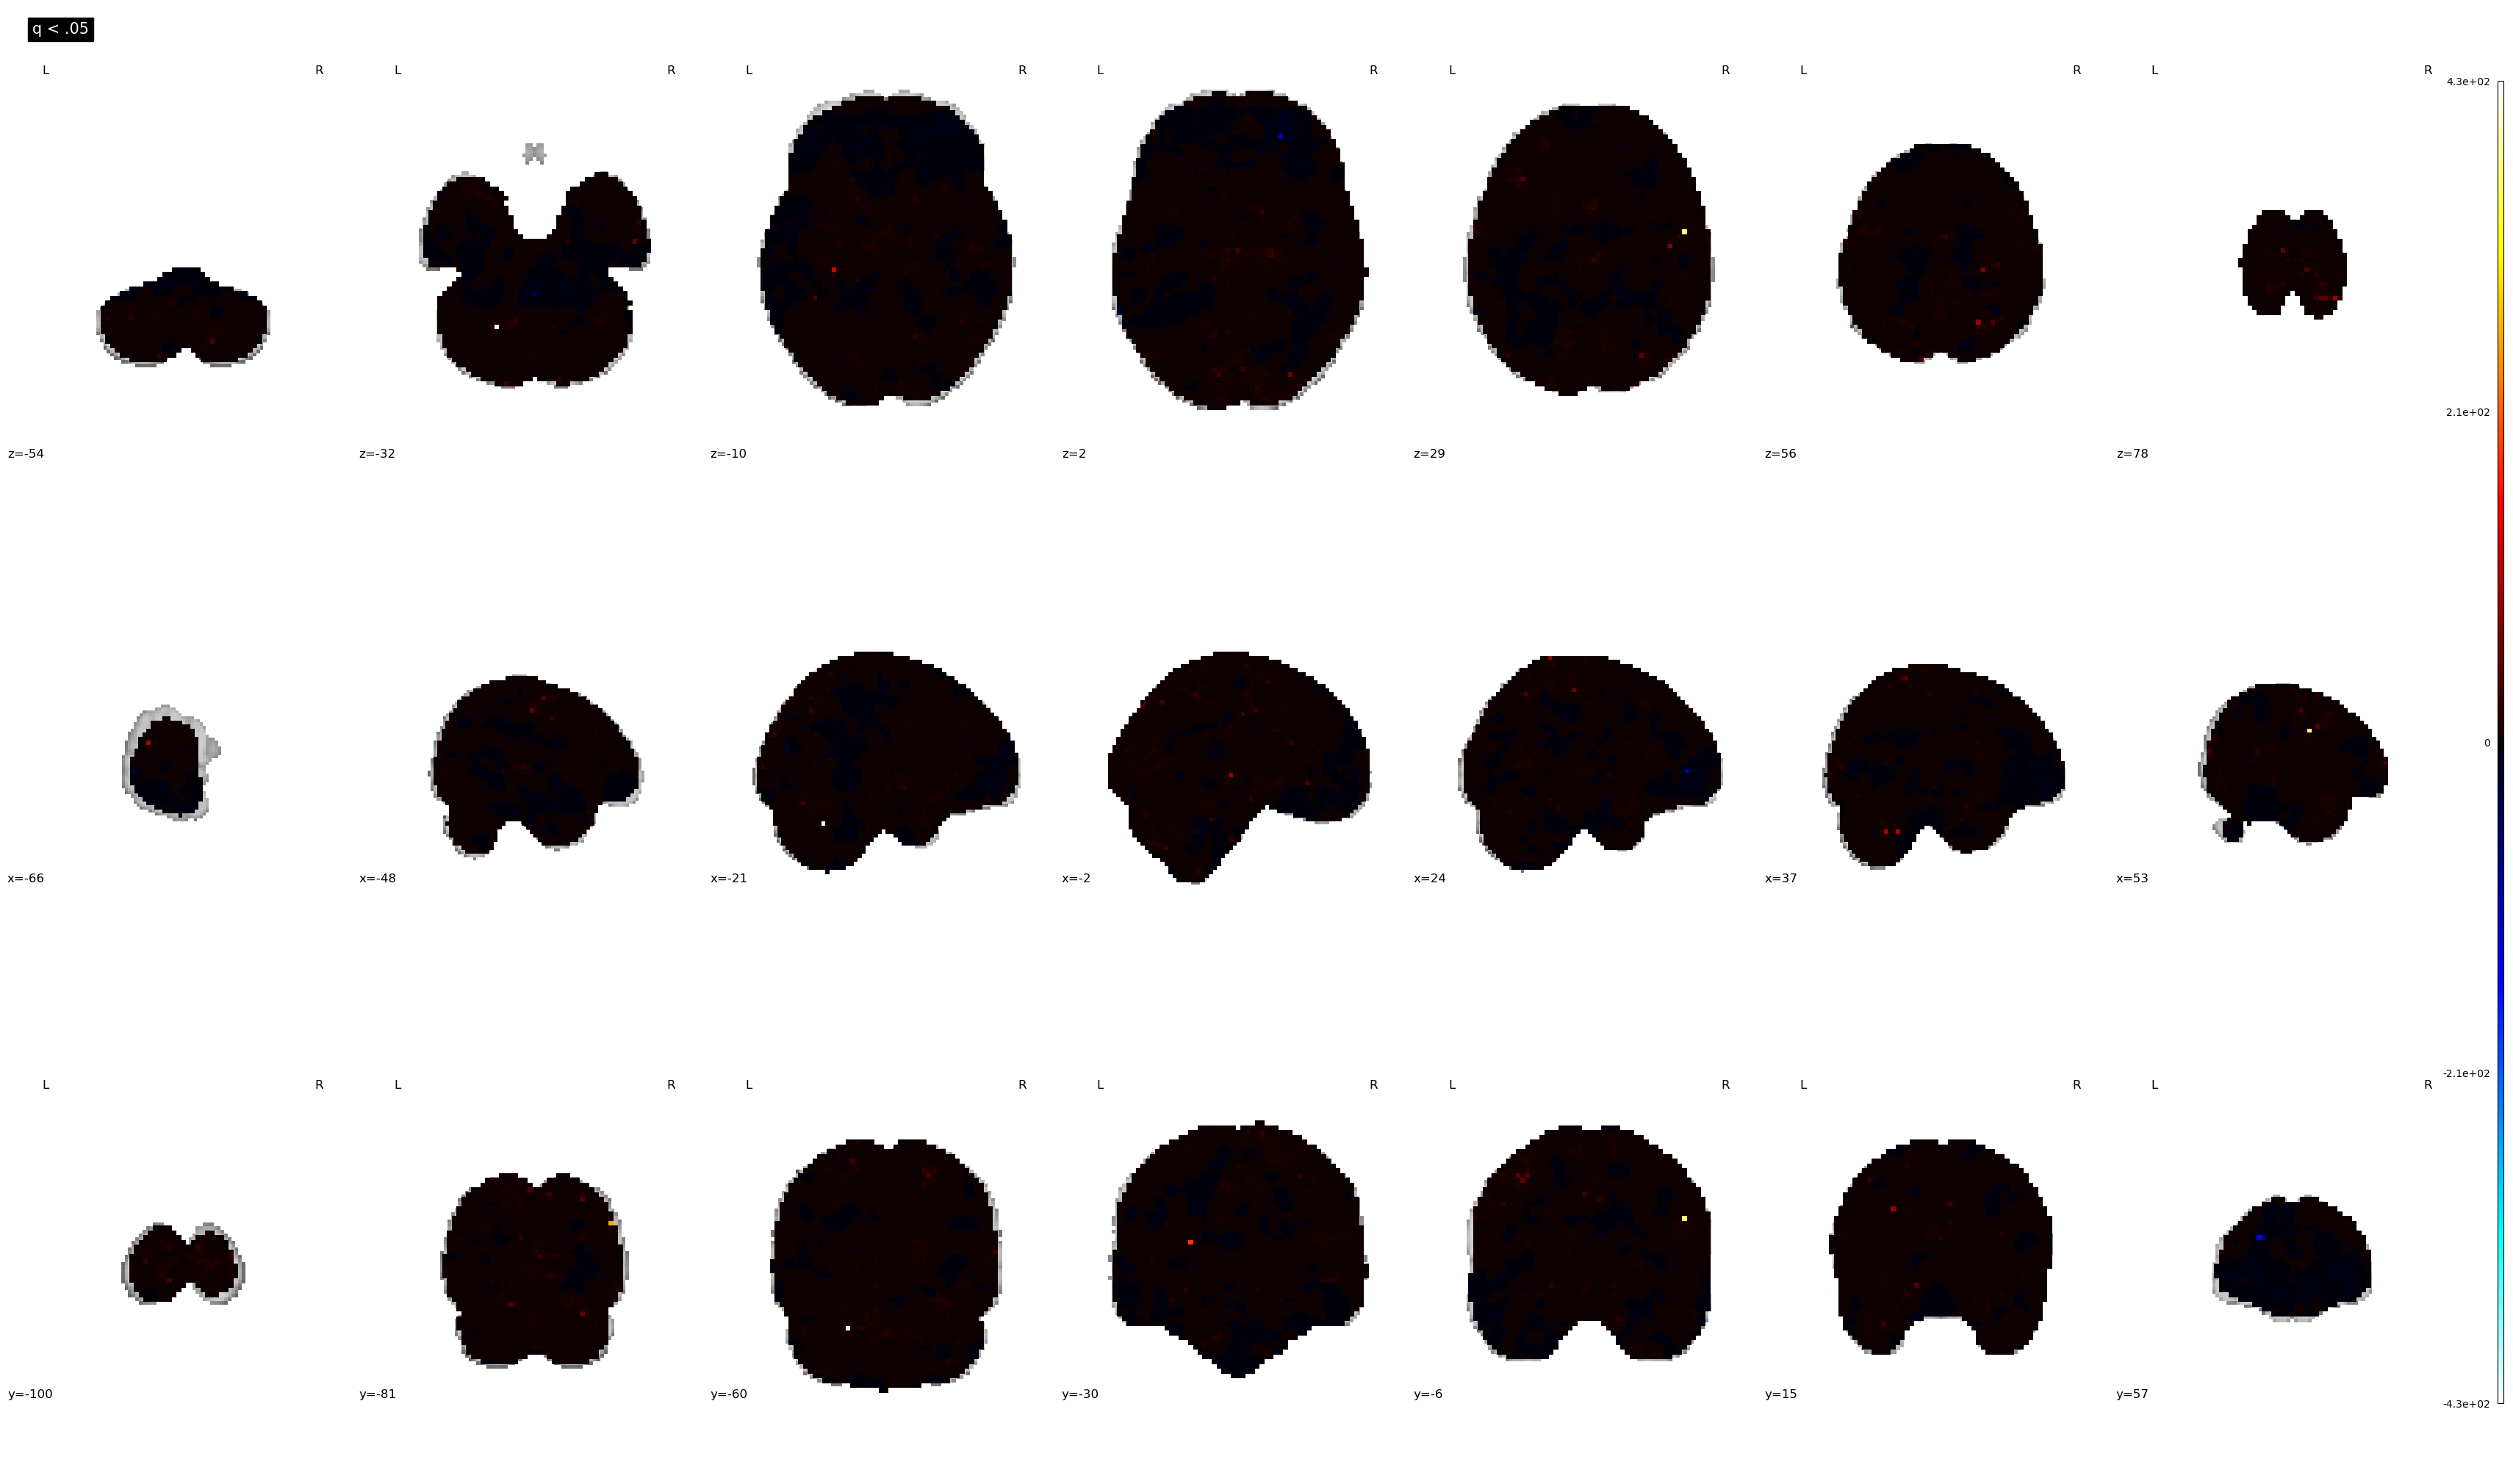

In [19]:
tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhigh, fmri_masked_stimlow, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
unthres_tmap = nifti_masker.inverse_transform(tvalues)

result_map = np.zeros(fmri_masked_stimhigh.shape[1])
result_map[qvalues < .05] = tvalues[qvalues < .05]
con_tmap = nifti_masker.inverse_transform(result_map)

result_map_001 = np.zeros(fmri_masked_stimhigh.shape[1])
result_map_001[qvalues < .0001] = tvalues[qvalues < .0001]
con_tmap_001 = nifti_masker.inverse_transform(result_map_001)

plotting.plot_stat_map(unthres_tmap,  display_mode = 'mosaic', title = 'q < .05')
# plotting.plot_stat_map(con_tmap_001,  display_mode = 'mosaic', title = 'q < .001')
# plotting.plot_stat_map(con_bmap, threshold = 1, display_mode = 'mosaic')
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename('singletrial-tmaprampup_task-pain_p-unthres.nii.gz')
con_tmap.to_filename('singletrial-tmaprampup_task-pain_q-05.nii.gz')
con_tmap_001.to_filename('singletrial-tmaprampup_task-pain_q-001.nii.gz')